In this tutorial, we will demonstrates how to implement PPO algorithm to solve a countinuous problem Inverted Pendulum.

Key learnings:

* How to create an environment in TorchRL, transform its outputs, and collect data from this environment;

* How to compute the general advantage estimation (GAE) for policy gradient methods;

* How to create a stochastic policy using a probabilistic neural network.

# Useful Functions
Here are some useful tools for the following training process. You can directly use them.

In [49]:
from tqdm import tqdm
import numpy as np
import torch
import collections
import random


# This is the replay buffer for storing the experience, note the transitions are collected with batch samples.
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)


# This is the function to smooth the curves by latest window_size (e.g. 100) timesteps' rewards.
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


# PPO

Proximal Policy Optimization (PPO) is a policy-gradient algorithm where a
batch of data is being collected and directly consumed to train the policy to maximise
the expected return given some proximality constraints. You can think of it
as a sophisticated version of [REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf),
the foundational policy-optimization algorithm. For more information, see the
[Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347) paper.

PPO is usually regarded as a fast and efficient method for online, on-policy
reinforcement algorithm. TorchRL provides a loss-module that does all the work
for you, so that you can rely on this implementation and focus on solving your
problem rather than re-inventing the wheel every time you want to train a policy.

For completeness, here is a brief overview of what the loss computes, the algorithm works as follows:
1. we will sample a batch of data by playing the
policy in the environment for a given number of steps.
2. Then, we will perform a given number of optimization steps with random sub-samples of this batch using
a clipped version of the REINFORCE loss.
3. The clipping will put a pessimistic bound on our loss: lower return estimates will
be favored compared to higher ones.
The precise formula of the loss is:

\begin{align}L(s,a,\theta_k,\theta) = \min\left(
    \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}  A^{\pi_{\theta_k}}(s,a), \;\;
    g(\epsilon, A^{\pi_{\theta_k}}(s,a))
    \right),\end{align}

There are two components in that loss: in the first part of the minimum operator,
we simply compute an importance-weighted version of the REINFORCE loss (for example, a
REINFORCE loss that we have corrected for the fact that the current policy
configuration lags the one that was used for the data collection).
The second part of that minimum operator is a similar loss where we have clipped
the ratios when they exceeded or were below a given pair of thresholds.

This loss ensures that whether the advantage is positive or negative, policy
updates that would produce significant shifts from the previous configuration
are being discouraged.

We now begin to build the backbone for PPO. It includes the following parts:



*   PPO
  *   Define policy Network
  *   Define actor Network
  *   Define advantage function with general advantage estimation (GAE)
  *   Define PPO agent
  *   Defien training process
  *   Train and plot

In [50]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define policy and value network

Because this environment is a continuous task, the policy need to be represented by a Gaussian-like stochastic policy. The actions are sampled from this policy.

The output of policy network is the mean and std of the gaussian distribution. The output of value network is the state value estimation.

In [51]:
# Define a 3-layer MLP as Policy Network
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


# Define a 3-layer MLP as Value Network
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)





# GAE
In this part, we define the advantage function as follows, which will be used in the PPO agent - policy update. The input is TD error.

In [52]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

# Define PPO Agent
Realize the PPO agent.

An abstract hint for policy update:

get transitions from buffer -> calculate the GAE advantage with TD error -> construct new policy and old policy distrubution, calculate the ratio and clipping parameters -> get new loss with clipping operation, make back-propogation and optimizer stepping.

In [53]:
class PPOContinuous:
    ''' PPO with clip for continuous tasks '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                    lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                                dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                                dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                                dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                    dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                                dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                        dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                                td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

# Define training process

In this part, we need to define the trainng episodes process. The output is the return list of the whole training process with multiple episodes' accumulated rewards.

If you have no idea about what to do, you can refer to the following instructions. (Only as an abstract hint.)

In each episode, you need to realize the following steps
* initialize episode return, transition dictionary, state
* while not terminate, do sample action -> env update -> save transition into buffers -> update to the new state and accumulate rewards -> update agents
* append episode returns and move to the next episode


In [54]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state,_ = env.reset()
                done = False
                epoch = 0
                while (not done and epoch<100):
                    epoch+=1
                    action = agent.take_action(state)
                    next_state, reward, done, _,_ = env.step(action)
                    # env.render()
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


# Start Training
With the above modules, we can start our training process here.
If you want to improve the performance, you can try to adjust the parameters as you wish. The training episodes are at least 2000.

In [55]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
# env = gym.make(env_name,render_mode="human")
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 200/200 [00:02<00:00, 74.09it/s, episode=2000, return=-294.650]


# Plot the results

In this part, we can plot the learning curves. The figure here is just an illustration, no need to recover this plot.

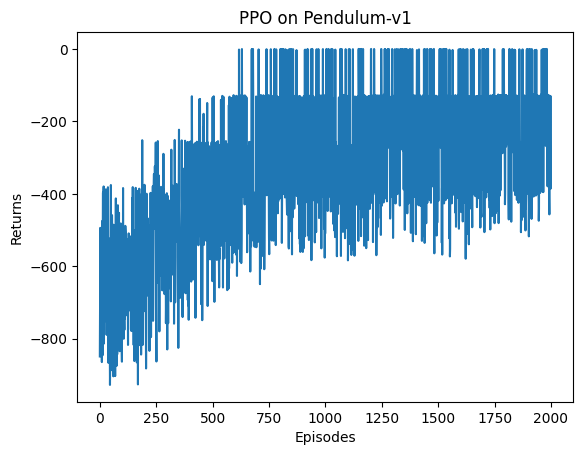

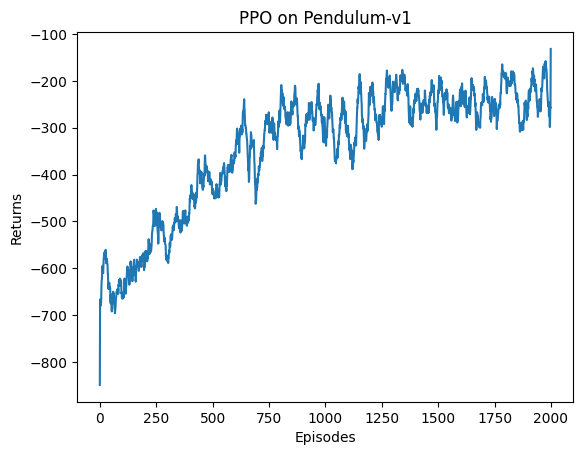

In [56]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

# Simple method to realize an RL algorithm

If you want to test other RL algorithms without building from scratch, you can use some popular libraries for RL. Here we make an example from official documents of stable-baseline3.

https://stable-baselines3.readthedocs.io/en/master/guide/examples.html

In this example, we use the SAC algorithm (Soft Actor Critic) to solve the same pendulum problem. You can see the training process and evaluation process as follows. If you are interested, give it a try on other popular algorithms such as DDPG, TD3, A2C, etc.

In [57]:
# !pip3 install gymnasium
# !pip3 install stable-baselines3

In [58]:
import os
import gymnasium as gym

from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env

env_id = "Pendulum-v1"
n_training_envs = 1
n_eval_envs = 5

# Create log dir where evaluation results will be saved
eval_log_dir = "./eval_logs/"
os.makedirs(eval_log_dir, exist_ok=True)

# Initialize a vectorized training environment with default parameters
train_env = make_vec_env(env_id, n_envs=n_training_envs, seed=0)

# Separate evaluation env, with different parameters passed via env_kwargs
# Eval environments can be vectorized to speed up evaluation.
eval_env = make_vec_env(env_id, n_envs=n_eval_envs, seed=0,
                        env_kwargs={'g':0.7})

# Create callback that evaluates agent for 5 episodes every 500 training environment steps.
# When using multiple training environments, agent will be evaluated every
# eval_freq calls to train_env.step(), thus it will be evaluated every
# (eval_freq * n_envs) training steps. See EvalCallback doc for more information.
eval_callback = EvalCallback(eval_env, best_model_save_path=eval_log_dir,
                              log_path=eval_log_dir, eval_freq=max(500 // n_training_envs, 1),
                              n_eval_episodes=5, deterministic=True,
                              render=False)

model = SAC("MlpPolicy", train_env)
model.learn(5000, callback=eval_callback)

Eval num_timesteps=500, episode_reward=-1376.87 +/- 291.18
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-101.12 +/- 74.31
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1500, episode_reward=-39.28 +/- 41.48
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-44.06 +/- 68.04
Episode length: 200.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-325.32 +/- 195.22
Episode length: 200.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-703.78 +/- 820.07
Episode length: 200.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-384.71 +/- 714.47
Episode length: 200.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-376.61 +/- 615.05
Episode length: 200.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-632.67 +/- 690.40
Episode length: 200.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-34.68 +/- 62.03
Episode length: 200.00 +/- 0.00
New best mean reward!


: 